### Topic Modeling

- Text preprocessing
- Identify 10 Topics by LDA
- Vizualize the topics using t-SNE and PCA 

In [1]:
!conda install -c anaconda pandas --yes
!conda install -c anaconda seaborn --yes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from scipy.stats import norm,skew,uniform
from scipy import stats
import datetime as dt
%matplotlib inline

Solving environment: done

## Package Plan ##

  environment location: /Users/asamitakeuchi/anaconda3

  added / updated specs:
    - pandas


The following packages will be UPDATED:

  ca-certificates    conda-forge/label/gcc7::ca-certificat~ --> anaconda::ca-certificates-2022.4.26-hecd8cb5_0 

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            pkgs/main::certifi-2023.7.22-py310hec~ --> anaconda::certifi-2022.6.15-py310hecd8cb5_0 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.



In [2]:
!conda install -c anaconda nltk --yes
import nltk
nltk.download ()
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from nltk.corpus import stopwords

!conda install -c conda-forge textblob --yes
from textblob import TextBlob
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from sklearn.compose import ColumnTransformer
!conda install -c "conda-forge/label/gcc7" wordcloud --yes
from wordcloud import WordCloud

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import warnings
warnings.filterwarnings('ignore')

Solving environment: done

# All requested packages already installed.

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
Solving environment: done

## Package Plan ##

  environment location: /Users/asamitakeuchi/anaconda3

  added / updated specs:
    - textblob


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-23.7.4               |  py310h2ec42d9_0        1010 KB  conda-forge
    openssl-1.1.1w             |       h8a1eda9_0         1.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.6 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/osx-64::python_abi-3.10-2_cp310 

The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2022.4.26-h~ --> conda-forge::ca-certificates-2023.7.22-h8857fd0_0 
 

In [3]:
train = pd.read_csv('/Users/asamitakeuchi/mercari/train_prepped.csv')
train_description = train['item_description']
train_name = train['name']

In [4]:
train_description[:20]

0     Plush Bambi from Disney Store. Tags still atta...
1     Worn twice, great condition. Color is mocha. S...
2                                                  BNWT
3     ALL SLIMES ARE BUY 2 GET ONE FREE! EXCLUDES [r...
4     Both are size 8. One pair are black skinny jea...
5     Push up silicone bra. Strapless. • Uplift brea...
6                  2 summer hats a swim suit and shorts
7     Rl polo Yellow. xl size. Brand new. Overstock ...
8           With gaming system and all cords and remote
9     Brand new Victoria's Secret body mist! Vanilla...
10    They will make any Harry Potter fan happy. I h...
11    Rudolph the Red Nosed Reindeer and Sam the Sno...
12    Brand new Authentic Better together pallet Thi...
13    ❤️Valentine Bundle Deals ❤️ ▪️ Bundle 2 listin...
14    Brand new in box, authentic, price non-negotiable
15    Britney Spears for the record Ships within 24 ...
16    Athleta super soft brushed cotton skirt size 2...
17    Velvet maroon headband, bought from Zumiez

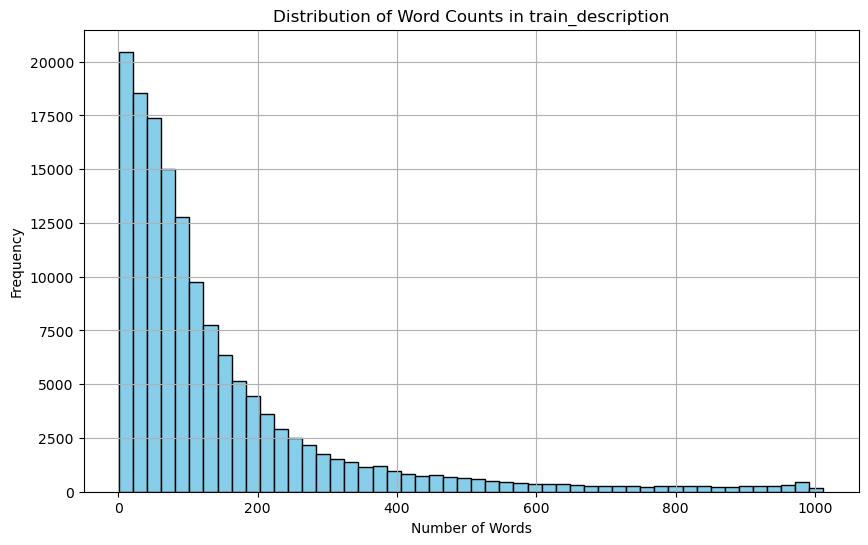

In [36]:
#check the ranking by the number of words of item_description
desc_nums = train_description.apply(lambda x : len(x) if type(x) != float else x )

plt.figure(figsize=(10, 6))
plt.hist(desc_nums, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in train_description')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
print(type(train_description))

<class 'pandas.core.series.Series'>


## Text preprocessing

In [7]:
#Preprocessing
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

# Assuming you have a DataFrame named 'train' with a column 'item_description'
# Replace this with your actual DataFrame
train_description = train['item_description']

def preprocess_text(text):
    if isinstance(text, str):  # Check if the value is a string
        # Remove emojis and unicode text
        text = text.encode('ascii', 'ignore').decode('utf-8')
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and punctuation
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Tokenize the text
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        
        # Lemmatize the tokens
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        # Join tokens back into a cleaned text
        cleaned_text = ' '.join(tokens)
        
        return cleaned_text
    else:
        return ""  # Return an empty string for non-string values

df = pd.DataFrame(train_description)
df['cleaned_description'] = df['item_description'].apply(preprocess_text)

# Display the cleaned descriptions
print(df['cleaned_description'])


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/asamitakeuchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asamitakeuchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/asamitakeuchi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0               plush bambi disney store tag still attached
1               worn twice great condition color mocha size
2                                                      bnwt
3         slime buy get one free excludes rm slime also ...
4         size one pair black skinny jean almost silvery...
                                ...                        
148249                                      description yet
148250    michael kor logo crossbody bag thin pink strap...
148251       authentic origami owl flat oval chain like new
148252    brand new never used tag still attached zipper...
148253              hand cream brand new oz body shop brand
Name: cleaned_description, Length: 148254, dtype: object


In [8]:
df['cleaned_description'].dtype

dtype('O')

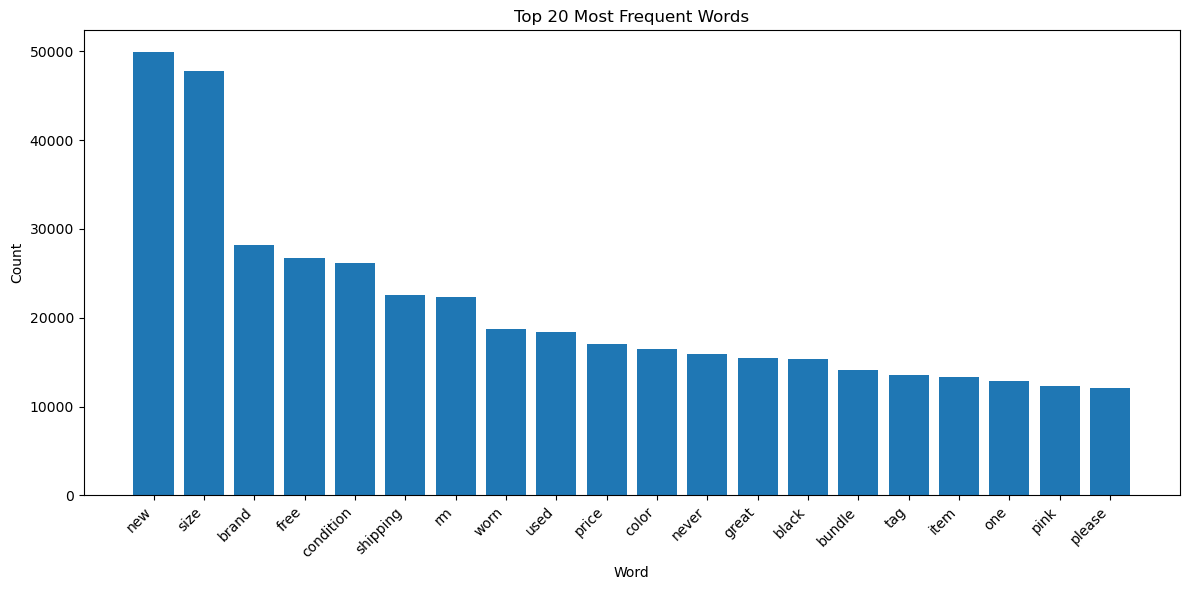

In [37]:
#Check the frequently available words
from collections import Counter
# Tokenize the cleaned descriptions
tokens = df['cleaned_description'].str.split().explode()

# Count the frequency of each word
word_counts = Counter(tokens)

# Convert word counts to a DataFrame for easier manipulation and plotting
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count']).reset_index()
word_counts_df.rename(columns={'index': 'word'}, inplace=True)

# Sort the words by count in descending order
word_counts_df = word_counts_df.sort_values(by='count', ascending=False)

# Plot the top N most frequent words (e.g., top 20)
top_n = 20
plt.figure(figsize=(12, 6))
plt.bar(word_counts_df['word'][:top_n], word_counts_df['count'][:top_n])
plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [13]:
#Vectorizing
tfidf_vectorizer = TfidfVectorizer(min_df=10,
                             max_features=180000,
                             ngram_range=(1, 2))
description_matrix = tfidf_vectorizer.fit_transform(list(df['cleaned_description']))
print('Headline after vectorization: \n{}'.format(description_matrix[0]))

Headline after vectorization: 
  (0, 31984)	0.31777882154059883
  (0, 33106)	0.3008011376924827
  (0, 32132)	0.4275961852608386
  (0, 9124)	0.3659291986867762
  (0, 1334)	0.2595798314602173
  (0, 31981)	0.18503265992274712
  (0, 32933)	0.14580493112915835
  (0, 32104)	0.23062941715169888
  (0, 9103)	0.2520347817475735
  (0, 2013)	0.3996892710808823
  (0, 24833)	0.3040588681127094


In [14]:
#LDA
lda_model = LatentDirichletAllocation(n_components=10,
                                      learning_method='online',
                                      max_iter=20,
                                      random_state=42)
X_topics = lda_model.fit_transform(description_matrix)

In [27]:
n_top_words = 20
topic_summaries = []

topic_word = lda_model.components_  # get the topic words
vocab = tfidf_vectorizer.get_feature_names_out()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: description yet | yet | description | time | worn time | couple time | couple | new size | worn couple | mug | price negotiable | steel | reasonable | negotiable | stainless | per | stainless steel | reasonable offer | vest | look like
Topic 1: bag | come | wore | matte | fit size | pop | anymore | lipstick | used | box | liquid | edition | set | tank top | come original | lip | euc | one | tank | tote
Topic 2: shipping | free | bundle | price | rm | item | free shipping | please | new | firm | ship | price firm | day | listing | save | brand | one | brand new | check | ask
Topic 3: condition | great | great condition | used | month | still | good | twice | shoe | size | shape | worn | good condition | baby | little | boy | girl | lot | really | left
Topic 4: woman | victoria | secret | victoria secret | nike | sign | shoe | wear | sign wear | reserved | size | book | size woman | game | condition | barely | original | pink | doll | card
Topic 5: black | size | pocket | white 

## Plotting by using TSNE

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
topics_2d = tsne.fit_transform(X_topics)

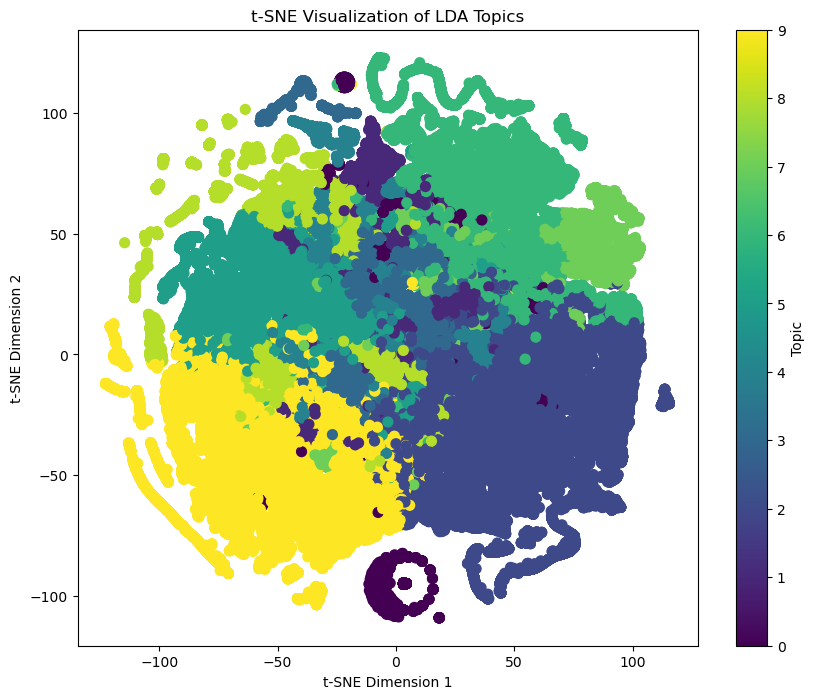

In [25]:
plt.figure(figsize=(10, 8))
plt.scatter(topics_2d[:, 0], topics_2d[:, 1], c=X_topics.argmax(axis=1), cmap='viridis', marker='o', s=50)
plt.colorbar(label='Topic')
plt.title('t-SNE Visualization of LDA Topics')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## Plotting by using PCA

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
topics_2d = pca.fit_transform(X_topics)

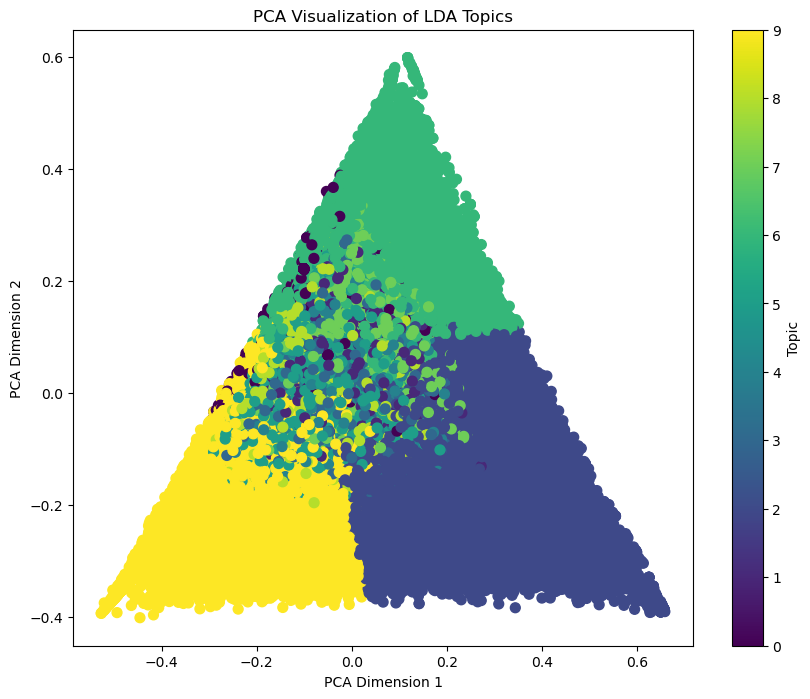

In [23]:
plt.figure(figsize=(10, 8))
plt.scatter(topics_2d[:, 0], topics_2d[:, 1], c=X_topics.argmax(axis=1), cmap='viridis', marker='o', s=50)
plt.colorbar(label='Topic')
plt.title('PCA Visualization of LDA Topics')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()